[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Chain 链

## 回顾

我们构建了一个简单的图，包含节点、普通边和条件边。

## 目标

现在，让我们构建一个简单的链条，它结合了4个[概念](https://python.langchain.com/v0.2/docs/concepts/):

* 使用[聊天消息](https://python.langchain.com/v0.2/docs/concepts/#messages)作为我们的图状态
* 使用[聊天模型](https://python.langchain.com/v0.2/docs/concepts/#chat-models)作为图节点
* [将工具绑定](https://python.langchain.com/v0.2/docs/concepts/#tools)到我们的聊天模型
* 在图节点中[执行工具调用](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling)

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## Messages 消息

聊天模型可以使用[`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages)，以捕捉对话中的不同角色。

LangChain 支持各种消息类型，包括`HumanMessage`, `AIMessage`, `SystemMessage` 和 `ToolMessage`. 

这些代表来自用户的消息、来自聊天模型的消息、用于聊天模型指导行为的消息以及来自工具调用的消息。

让我们创建一个消息列表。

每条消息都可以提供一些内容：

* `content` - 消息内容
* `name` - 可选，消息作者
* `response_metadata` - 可选，元数据字典(e.g.,通常由模型提供者填充在`AIMessages`中)

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [HumanMessage(content=f"你好",name="Lance")]
messages.append(AIMessage(content=f"你好! 今天有什么我可以帮你的吗?", name="Assistant"))
messages.append(HumanMessage(content=f"就请跟我聊聊天吧", name="Lance"))
messages.append(AIMessage(content=f"当然可以! 我已经准备好了。告诉我你的想法? 有没有你特别想讨论的话题，或者您只是在寻找随意的交谈？", name="Assistant"))
messages.append(HumanMessage(content=f"请你帮我找个话题吧", name="Lance"))

for m in messages:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

你好
================================== Ai Message ==================================
Name: Assistant

你好! 今天有什么我可以帮你的吗?
================================ Human Message =================================
Name: Lance

就请跟我聊聊天吧
================================== Ai Message ==================================
Name: Assistant

当然可以! 我已经准备好了。告诉我你的想法? 有没有你特别想讨论的话题，或者您只是在寻找随意的交谈？
================================ Human Message =================================
Name: Lance

请你帮我找个话题吧


## 聊天模型

[聊天模型](https://python.langchain.com/v0.2/docs/concepts/#chat-models)可以使用一系列消息作为输入，并支持上述讨论的消息类型。

有[很多](https://python.langchain.com/v0.2/docs/concepts/#chat-models)选择！我选择使用qwen的openai兼容接口。

下边导入模型的配置

In [2]:
# 官方的配置方式，由用户输入openai的api key，然后设置到环境变量
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [5]:
# 我没有openai的api key，所以使用qwen的openai兼容接口，需要设置qwen的api key和base url，我选着从配置文件.yml中读取
import yaml

with open('../.yml', 'r') as file:
    config = yaml.safe_load(file)

# 获取配置信息(以.yml_example的例子)
qwen_config = config['llm']['qwen']

我们可以加载一个聊天模型，并用我们的消息列表调用它。

我们可以看到结果是一个`AIMessage`并包含特定的`response_metadata`.

In [6]:
from langchain_openai import ChatOpenAI
# 使用qwen的openai兼容接口，且没有用环境变量，这里直接通过参数设置
llm = ChatOpenAI(api_key=qwen_config['api_key'],base_url=qwen_config['base_url'],model="qwen-max")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [7]:
result

AIMessage(content='好的，那我们就来聊聊旅行吧！旅行是一个很有趣的话题。你最近有没有去过什么有趣的地方？或者有没有什么地方是你一直梦想去的？如果有机会的话，你是更喜欢自然风光的探险，还是更倾向于历史文化的城市游呢？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 80, 'total_tokens': 132, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'qwen-max', 'system_fingerprint': None, 'id': 'chatcmpl-2de4d43e-cabf-9427-b9a0-ecd5dbe9bc1a', 'finish_reason': 'stop', 'logprobs': None}, id='run-67fd5d14-1b8d-4a1e-8868-45443f75e165-0', usage_metadata={'input_tokens': 80, 'output_tokens': 52, 'total_tokens': 132, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}})

In [8]:
result.response_metadata

{'token_usage': {'completion_tokens': 52,
  'prompt_tokens': 80,
  'total_tokens': 132,
  'completion_tokens_details': None,
  'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}},
 'model_name': 'qwen-max',
 'system_fingerprint': None,
 'id': 'chatcmpl-2de4d43e-cabf-9427-b9a0-ecd5dbe9bc1a',
 'finish_reason': 'stop',
 'logprobs': None}

## 工具

工具在您希望模型与外部系统交互时非常有用。

外部系统（例如，API）通常需要特定的输入模式或有效载荷，而不是自然语言。

例如，当我们将API绑定为一个工具时，我们给模型提供了对所需输入模式的认知。

模型将根据用户的自然语言输入选择调用工具。

并且，它将返回符合工具模式的输出。

[许多LLM提供商支持工具调用](https://python.langchain.com/v0.1/docs/integrations/chat/)，并且LangChain中的[工具调用接口](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/)很简单
 
您可以简单地传递任何 Python`function` 到 `ChatModel.bind_tools(function)`。

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

让我们展示一个工具调用的简单示例！
 
`multiply`函数是我们的工具。

In [10]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

如果我们传递一个输入，例如 `"2乘以3等于几？"`，我们会看到一个工具调用返回。
工具调用具有特定的参数，这些参数与我们的函数输入模式相匹配，并包括要调用的函数名称。

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [11]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"3乘以7等于几？", name="Lance")])

In [12]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 3, 'b': 7},
  'id': 'call_287b6a7e21974bd4bc870c',
  'type': 'tool_call'}]

## 使用消息作为状态

在这些基础已经建立之后，我们现在可以在我们的图状态中使用[`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages)

让我们定义我们的状态，`MessagesState`为一个具有单个键（`messages`）的 `TypedDict`

`messages` 简单来说就是上面定义的消息列表 (例如`HumanMessage`等).

In [1]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers 状态汇总函数，是langgraph 中用于指定状态更新方式的函数。

现在，我们遇到了一个小问题！

正如我们讨论的，每个节点将为我们的状态键`messages`返回一个新值。

但是，这个新值将[覆盖](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)之前的`messages`值。
 
当我们的图运行时，我们希望将消息**追加**到我们的`messages`状态键中。
 
我们可以使用[reducer函数](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)来解决这个问题。

Reducers允许我们指定状态更新的方式。

如果没有指定 reducer 函数，则默认认为更新到键的值应该覆盖之前的值，就像我们之前看到的那样。
 
但是，为了追加消息，我们可以使用预构建的`add_messages`状态汇总函数.

这确保了任何消息都会追加到现有的消息列表中。

我们只需将我们的`messages`键注解为`add_messages`状态汇总函数作为元数据即可。

In [8]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

由于在图状态中拥有消息列表非常常见，LangGraph有预构建的[`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState`被定义：

* 使用预构建的单个`messages`键
* 这是一个`AnyMessage`对象的列表 
* 它使用`add_messages`状态汇总函数

我们通常会使用`MessagesState`，因为它比定义自定义的`TypedDict`更简洁.

In [2]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

深入一点，我们可以单独看看`add_messages`状态汇总函数是如何工作的。

In [9]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='f6d2e57e-4326-40ed-a629-db52f7f8d9e0'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='14f42350-1f6b-4826-ad22-f95affa89198'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='40590bef-4369-4fae-9f76-b6e7c18094f9')]

## 我们的图

现在，让我们用一个图表来使用`MessagesState`

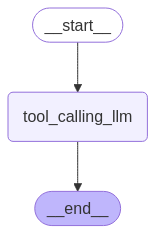

In [13]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

如果我们传入`Hello!`，LLM将无任何工具调用作出响应。

In [14]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


当LLM确定输入或任务需要该工具提供的功能时，会选择使用该工具。

In [15]:
messages = graph.invoke({"messages": HumanMessage(content="二乘八等于几？")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

二乘八等于几？
================================== Ai Message ==================================
Tool Calls:
  multiply (call_7a3bf6c78e444dd8aedeb7)
 Call ID: call_7a3bf6c78e444dd8aedeb7
  Args:
    a: 2
    b: 8
